In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import wbdata
import datetime
import pycountry
import collections
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
G2000=nx.read_pajek("2000.net")
G2000=nx.Graph(G2000)
mask=pd.DataFrame.from_dict(dict(G2000.nodes(data=True)),orient='index').reset_index()

In [3]:
def data_olv(name):
    import2000=pd.read_csv(name).drop(columns=['SourceNomenCode',
                                                           'DestNomenCode','TradeFlow','ProductCode','Quantity',
                                                           'QuantityToken','NetWeight','Year'])
    import2000=import2000.rename(columns={"ReporterISO3":'source', 'PartnerISO3':'target', 'TradeValue':'weight'})
    import2000=import2000.groupby(['source','target']).agg({'weight':'sum'}).reset_index()
    import2000=import2000[import2000.target.isin(mask['index'])]
    import2000=import2000[import2000.source.isin(mask['index'])]
    import2000=import2000[import2000['source']!=import2000['target']]
    import2000=import2000.reset_index(drop=True)
    Y=nx.Graph()
    Y=nx.from_pandas_edgelist(import2000, 'source', 'target', ['weight'])
    nx.set_node_attributes(Y, mask.set_index('index').to_dict('index'))
    return import2000, Y

edges2000, Y2000=data_olv('Import2000.csv')
edges2005, Y2005=data_olv('Import2005.csv')
edges2010, Y2010=data_olv('Import2010.csv')
edges2015, Y2015=data_olv('Import2015.csv')
edges2018, Y2018=data_olv('Import2018.csv')

In [4]:
def degree_plot(ax,ay,G,cim):    
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    axes[ax,ay].scatter(deg, cnt, color='b')

    axes[ax,ay].set_title(cim)
    axes[ax,ay].set_ylabel("Count")
    axes[ax,ay].set_xlabel("Degree")

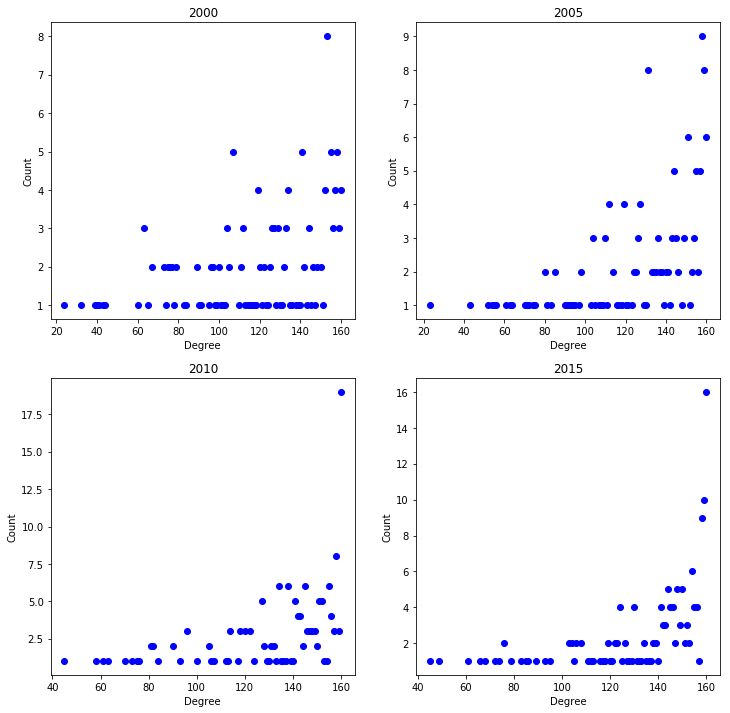

In [5]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
degree_plot(0,0,Y2000, "2000")
degree_plot(0,1,Y2005, "2005")
degree_plot(1,0,Y2010, "2010")
degree_plot(1,1,Y2015, "2015")

In [51]:
nodess=pd.DataFrame(columns=['id','x','y','shape','year','Degree','Clustering coef'])

def clustering_plot(ax,ay,G,cim, nodess):
    deg_df=pd.DataFrame(nx.degree(G), columns=['Country','Degree']).set_index('Country')
    clus_df=pd.DataFrame.from_dict(nx.clustering(G), orient='index', columns=['Clustering coef'])
    deg_df=deg_df.merge(clus_df, left_index=True, right_index=True)
    node=nodess
    if cim==2000:
        nodes=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
        nodes['year']=cim
        node=nodes.merge(deg_df, left_index=True, right_index=True)
    else:
        nodes1=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
        nodes1['year']=cim
        nodes1=nodes1.merge(deg_df, left_index=True, right_index=True)
        frames=[node,nodes1]
        node=pd.concat(frames, axis=0)

    axes[ax,ay].set_title(cim)
    axes[ax,ay].set_ylabel("Clustering")
    axes[ax,ay].set_xlabel("Degree")
    
    
    axes[ax,ay].plot(node["Degree"],node["Clustering coef"],"o")
    
    return node

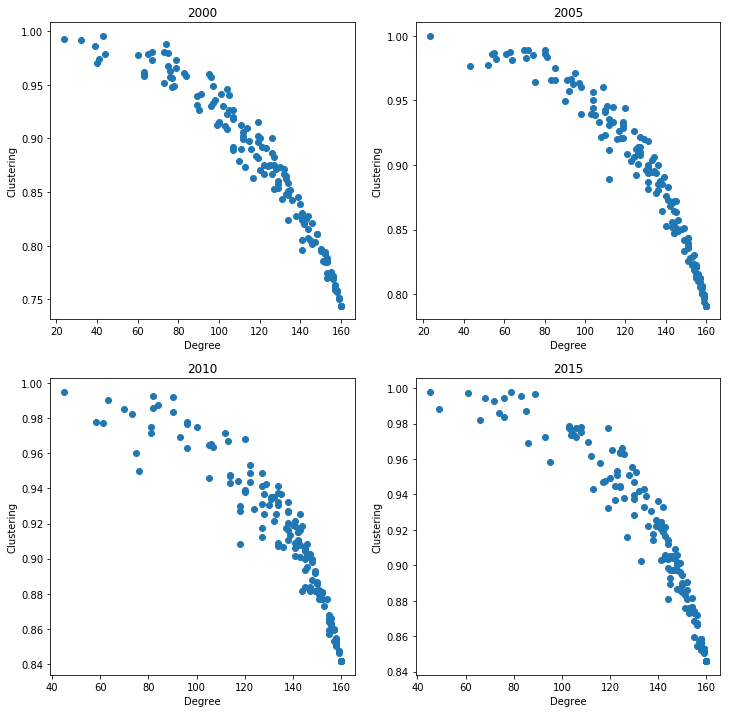

In [52]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
nodes=clustering_plot(0,0,Y2000, 2000, nodess)
nodes=clustering_plot(0,1,Y2005, 2005, nodess)
nodes=clustering_plot(1,0,Y2010, 2010, nodess)
nodes=clustering_plot(1,1,Y2015, 2015, nodess)

In [53]:
def nodes_gen(G,cim, nodess):
    deg_df=pd.DataFrame(nx.degree(G), columns=['Country','Degree']).set_index('Country')
    clus_df=pd.DataFrame.from_dict(nx.clustering(G), orient='index', columns=['Clustering coef'])
    neigh_df=pd.DataFrame.from_dict(nx.average_neighbor_degree(G), orient='index', columns=['Average neighbor degree'])
    between_df=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index', columns=['Betweenness centrality'])
    random_walk_df=pd.DataFrame.from_dict(nx.current_flow_betweenness_centrality(G), 
                                                  orient='index', columns=['Random walk betweenness centrality'])
    deg_df=deg_df.merge(random_walk_df, left_index=True, right_index=True)
    deg_df=deg_df.merge(between_df, left_index=True, right_index=True)
    deg_df=deg_df.merge(neigh_df, left_index=True, right_index=True)
    deg_df=deg_df.merge(clus_df, left_index=True, right_index=True)
    node=nodess
    if cim==2000:
        nodes=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
        nodes['year']=cim
        node=nodes.merge(deg_df, left_index=True, right_index=True)
    else:
        nodes1=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
        nodes1['year']=cim
        nodes1=nodes1.merge(deg_df, left_index=True, right_index=True)
        frames=[node,nodes1]
        node=pd.concat(frames, axis=0)
    return node

In [54]:
nodes=nodes_gen(Y2000, 2000, nodess)
nodes=nodes_gen(Y2005, 2005, nodes)
nodes=nodes_gen(Y2010, 2010, nodes)
nodes=nodes_gen(Y2015, 2015, nodes)
#nodes=nodes_gen(Y2018, 2018, nodes)
input_countries=nodes.index
input_countries=pd.DataFrame(input_countries, columns=["Countries"])

iso2=[]
iso3=[]
count=[]
countries = {}
for country in pycountry.countries:
    iso2.append(country.alpha_2)
    iso3.append(country.alpha_3)
    count.append(country.name)
    
countries=pd.DataFrame(iso3,iso2, columns=["iso3"]).reset_index()
countries["name"]=count
nodes=nodes.merge(countries,left_index=True, right_on="iso3",how='left')


gross2000=edges2000.groupby('source').sum().rename(columns={'weight':'gross import'})
gross2005=edges2005.groupby('source').sum().rename(columns={'weight':'gross import'})
gross2010=edges2010.groupby('source').sum().rename(columns={'weight':'gross import'})
gross2015=edges2015.groupby('source').sum().rename(columns={'weight':'gross import'})
#gross2018=edges2018.groupby('source').sum()

imp00=nodes.merge(gross2000, left_on='iso3', right_index=True, how='left')
imp00=imp00[imp00['year']==2000]
imp05=nodes.merge(gross2005, left_on='iso3', right_index=True, how='left')
imp05=imp05[imp05['year']==2005]
imp10=nodes.merge(gross2010, left_on='iso3', right_index=True, how='left')
imp10=imp10[imp10['year']==2010]
imp15=nodes.merge(gross2015, left_on='iso3', right_index=True, how='left')
imp15=imp15[imp15['year']==2015]
nodes=pd.concat([imp00,imp05,imp10,imp15], axis=0)


def wbadat(times, tab, indicat, name):
    indicator={indicat:name}
    tab2=pd.DataFrame()
    for i in times:
        data_date = (datetime.datetime(i, 1, 1))
        try:
            population=wbdata.get_data(indicat, data_date=data_date)
            population=pd.DataFrame(population).drop(columns=['decimal','indicator','date'])
            population['index']=[f['id'] for f in population['country']]
            population=population.drop(columns=["country"])
            population=population.dropna()
            population['value']=round(population['value'].astype(float),2)
            population=population.rename(columns={"value":name})
            
            tab1=tab.merge(population, left_on=["index"], right_on=["index"], how="left")
            
            tab1=tab1[tab1['year']==i]
            if i==2000:
                tab2=tab1
            else:
                frames=[tab1,tab2]
                tab2=pd.concat(frames, axis=0)

        except:
            'foo'        
    return tab2

dates=[2000,2005,2010,2015]


nodes=wbadat(dates, nodes,'NY.GDP.PCAP.KD', "constantGDP_percapita")
nodes=wbadat(dates, nodes,'CC.PER.RNK', "corruption_index")
nodes=wbadat(dates, nodes,'SI.POV.GINI', "GINI")
nodes=wbadat(dates, nodes,'NY.GDP.PCAP.KD.ZG', "per capita GDP growth")
nodes=wbadat(dates, nodes,'TG.VAL.TOTL.GD.ZS', "Trade % of GDP")
nodes=wbadat(dates, nodes,'SH.XPD.GHED.GD.ZS', "gov_expend_on_health_%GDP")
nodes=wbadat(dates, nodes,'BX.KLT.DINV.WD.GD.ZS', "FDI_inflow_%GDP")
nodes=wbadat(dates, nodes,'SE.XPD.TOTL.GD.ZS', "gov_expend_on_educ_%GDP")
nodes=wbadat(dates, nodes,'SE.TER.ENRR', "tetrietary_school_enrollment")
nodes=wbadat(dates, nodes,'NY.GDP.TOTL.RT.ZS', "natural_resource_rents_%GDP")
nodes=wbadat(dates, nodes,'TX.VAL.ICTG.ZS.UN', "ICT_goods_export%exports")
nodes=wbadat(dates, nodes,'GB.XPD.RSDV.GD.ZS', "R&D_expenditues%GDP")
nodes=wbadat(dates, nodes,'FS.AST.PRVT.GD.ZS', "domestic_credit_to_private_sector%GDP")

development=pd.read_excel('UNSD — Methodology.xlsx')
development=development.drop(columns=['Global Code','Global Name',
                                      'Region Code', 'Sub-region Code', 'Intermediate Region Code',
                                      'Intermediate Region Name','Country or Area', 'M49 Code'])
nodes=nodes.merge(development, left_on='iso3', right_on='ISO-alpha3 Code',
                  how='left', copy=False).drop(columns=['ISO-alpha3 Code'])

nodes=nodes.sort_values(['year','name'])
nodes['gross import']=nodes['gross import'].apply(lambda x: np.nan if np.isnan(x) else x)
nodes

id       x       y   shape  year  Degree  \
483    2  0.5560  0.7286  0.5000  2000     101   
574   44  0.5046  0.6557  0.5000  2000     141   
562    1  0.5496  0.4378  0.5000  2000      63   
625    6  0.3283  0.5948  0.5000  2000      97   
485    4  0.3233  0.2866  0.5000  2000     146   
486    5  0.6251  0.7226  0.5000  2000      91   
487    7  0.8716  0.3596  0.5000  2000     157   
488    8  0.5404  0.7640  0.5000  2000     160   
489    9  0.6322  0.7230  0.5000  2000     103   
566   17  0.2850  0.6391  0.5000  2000     111   
565   16  0.6407  0.6441  0.5000  2000     120   
564   14  0.7510  0.6316  0.5000  2000     146   
567   23  0.3346  0.5733  0.5000  2000     131   
493   19  0.5776  0.7984  0.5000  2000     127   
490   11  0.5124  0.7806  0.5000  2000     156   
630   12  0.5064  0.5517  0.5000  2000     110   
626   20  0.3201  0.6796  0.5000  2000      67   
632   25  0.7512  0.6529  0.5000  2000      40   
494   21  0.3234  0.4095  0.5000  2000     107   
492   18  0.5491  0.7440  0.5000  2000      74   
568   26  0.5686  0.3760  0.5000  2000      78   
495   22  0.3558  0.4209  0.5000  2000     155   
631   24  0.8187  0.5252  0.5000  2000      67   
491   15  0.5708  0.7374  0.5000  2000     150   
563   13  0.4957  0.5680  0.5000  2000     117   
629   10  0.5831  0.4813  0.5000  2000      83   
587   84  0.7916  0.5698  0.5000  2000     107   
570   33  0.5343  0.5409  0.5000  2000     127   
497   28  0.2046  0.8118  0.5000  2000     158   
496   27  0.5582  0.5367  0.5000  2000      90   
613  141  0.5520  0.5859  0.5000  2000      60   
569   30  0.3013  0.3018  0.5000  2000     134   
499   31  0.7894  0.6992  0.5000  2000     156   
501   35  0.2936  0.5254  0.5000  2000     151   
572   36  0.6219  0.4340  0.5000  2000      73   
571   34  0.5440  0.4987  0.5000  2000      77   
502   37  0.2674  0.5542  0.5000  2000     133   
517   68  0.5422  0.7506  0.5000  2000     145   
503   38  0.5929  0.6951  0.5000  2000     148   
504   39  0.5430  0.7768  0.5000  2000     155   
500   32  0.4846  0.5419  0.5000  2000     128   
506   42  0.5264  0.8126  0.5000  2000     153   
627   41  0.3295  0.5856  0.5000  2000     104   
573   43  0.3051  0.6041  0.5000  2000      95   
507   45  0.2828  0.4898  0.5000  2000     138   
508   46  0.5856  0.6490  0.5000  2000     139   
611  134  0.2531  0.5766  0.5000  2000     119   
642   61  0.5285  0.5092  0.5000  2000      44   
633   47  0.6105  0.5843  0.5000  2000      43   
510   49  0.5695  0.8255  0.5000  2000     144   
612  139  0.5874  0.3527  0.5000  2000     112   
575   50  0.6125  0.5508  0.5000  2000     129   
576   52  0.9984  0.4079  0.5000  2000      63   
511   51  0.5715  0.8440  0.5000  2000     153   
512   53  0.5061  0.7568  0.5000  2000     160   
577   54  0.5322  0.4955  0.5000  2000     114   
634   59  0.4575  0.5747  0.5000  2000      89   
514   56  0.6204  0.7351  0.5000  2000      99   
505   40  0.5290  0.7843  0.5000  2000     160   
578   57  0.4972  0.5441  0.5000  2000     134   
515   62  0.5606  0.7171  0.5000  2000     152   
580   63  0.3289  0.5681  0.5000  2000     111   
581   64  0.2494  0.5877  0.5000  2000     104   
579   58  0.4731  0.5553  0.5000  2000     122   
641   60  0.4578  0.5656  0.5000  2000      41   
582   65  0.3363  0.5270  0.5000  2000     112   
518   69  0.2992  0.6054  0.5000  2000      76   
583   67  0.2604  0.5844  0.5000  2000     119   
516   66  0.8170  0.6244  0.5000  2000     150   
519   70  0.5542  0.7620  0.5000  2000     153   
584   75  0.4472  0.8609  0.5000  2000     126   
521   72  0.7193  0.6144  0.5000  2000     152   
520   71  0.8164  0.4956  0.5000  2000     155   
523   74  0.6491  0.6802  0.5000  2000     133   
522   73  0.4771  0.7967  0.5000  2000     157   
524   76  0.5968  0.6725  0.5000  2000     134   
525   77  0.5349  0.7326  0.5000  2000     158   
526   78  0.2853  0.6006  0.5000  2000     123   
528   80  0.8840  0.7011  0.5000  2000     159   
527   

# Global properties

In [55]:
networks=[Y2000,Y2005,Y2010,Y2015,Y2018]
years=[2000,2005,2010,2015,2018]

def global_properties(G, years):
    global_df=pd.DataFrame()
    for i in range(len(years)):
        data={"year":years[i], "N": [len(nx.nodes(G[i]))], "L": [len(nx.edges(G[i]))], "<k>": [2*len(nx.edges(G[i]))/len(nx.nodes(G[i]))], 
                                   "diameter": [nx.diameter(G[i])], "node connectivity":[nx.node_connectivity(G[i])],
                                   "density": [nx.density(G[i])], "assortativity coef": [nx.degree_assortativity_coefficient(G[i])]}
        global_df=global_df.append(pd.DataFrame(data))
    return global_df.reset_index(drop=True)


glob_df=global_properties(networks,years)
glob_df

year    N      L         <k>  diameter  node connectivity   density  \
0  2000  161   9628  119.602484         2                 24  0.747516   
1  2005  161  10223  126.993789         2                 23  0.793711   
2  2010  161  10866  134.981366         2                 45  0.843634   
3  2015  161  10919  135.639752         2                 45  0.847748   
4  2018  161  10117  125.677019         2                 36  0.785481   

   assortativity coef  
0           -0.235076  
1           -0.219576  
2           -0.177701  
3           -0.199231  
4           -0.320070

--------------------------

# Herfindalh

In [56]:
edgeframes=[edges2000,edges2005,edges2010,edges2015,edges2018]

def herfindahl(edgeframes, years):
    herfi=pd.DataFrame()
    for i in range(len(years)):
        df1=edgeframes[i].groupby(['source','target']).sum()
        df2=edgeframes[i].groupby(['source']).sum()
        df1=df1.merge(df2, left_index=True, right_index=True)
        df1['herfindahl index']=(df1['weight_x']*100/df1['weight_y'])**2
        df1=df1.reset_index().groupby('source').sum().sort_values('herfindahl index', 
                                                                      ascending=False).drop(columns=['weight_x',
                                                                                                     'weight_y'])
        df1['year']=years[i]
        
        herfi=herfi.append(df1)
    return herfi.reset_index()
    
herfindahl_df=herfindahl(edgeframes, years)

In [57]:
nodes_herf=nodes.merge(herfindahl_df, left_on=['iso3','year'], right_on=['source','year'], how='left').drop(columns='source')
nodes_herf.sort_values('herfindahl index').T

71               206  \
id                                                  72               46   
x                                               0.7193           0.5856   
y                                               0.6144            0.649   
shape                                           0.5000           0.5000   
year                                              2000             2005   
Degree                                             152              145   
Random walk betweenness centrality           0.0112149       0.00904244   
Betweenness centrality                      0.00325177       0.00146434   
Average neighbor degree                        122.684          132.648   
Clustering coef                               0.785988         0.863506   
index                                               IN               EG   
iso3                                               IND              EGY   
name                                             India            Egypt   
gross import                               3.79255e+07      1.62954e+07   
constantGDP_percapita                           826.59          2147.82   
corruption_index                                 44.16            31.22   
GINI                                               NaN              NaN   
per capita GDP growth                             2.02              2.6   
Trade % of GDP                                   20.05            39.43   
gov_expend_on_health_%GDP                         0.83             1.59   
FDI_inflow_%GDP                                   0.77             5.99   
gov_expend_on_educ_%GDP                           4.32             4.79   
tetrietary_school_enrollment                      9.51            30.12   
natural_resource_rents_%GDP                       2.42            14.37   
ICT_goods_export%exports                          1.69             0.13   
R&D_expenditues%GDP                               0.76             0.24   
domestic_credit_to_private_sector%GDP            28.34            51.17   
Region Name                                       Asia           Africa   
Sub-region Name                          Southern Asia  Northern Africa   
Least Developed Countries (LDC)                      0                0   
Land Locked Developing Countries (LLDC)              0                0   
Small Island Developing States (SIDS)                0                0   
Developed / Developing Countries                     0                0   
WTO                                                  1                1   
herfindahl index                               429.072           435.59   

                                                     367  \
id                                                    46   
x                                                 0.5856   
y                                                  0.649   
shape                                             0.5000   
year                                                2010   
Degree                                               155   
Random walk betweenness centrality            0.00887004   
Betweenness centrality                        0.00161163   
Average neighbor degree                          136.768   
Clustering coef                                 0.865941   
index                                                 EG   
iso3                                                 EGY   
name                                               Egypt   
gross import                                 5.11437e+07   
constantGDP_percapita                            2644.82   
corruption_index                                   30.95   
GINI                                                30.2   
per capita GDP growth                               3.08   
Trade % of GDP                                     36.26   
gov_expend_on_health_%GDP                           1.37   
FDI_inflow_%GDP                                     2.92   
gov_expend_on_educ_%GDP       

In [58]:
def custom_plot(ax,ay,nodes,X,Y,cim):
    nodes=nodes[nodes['year']==cim]
    sns.regplot(nodes[X], nodes[Y], ax=axes[ax,ay], truncate=True)
    #axes[ax,ay].scatter(nodes[X], nodes[Y], color='b')
    axes[ax,ay].set_title(cim)
    axes[ax,ay].set_ylabel(Y)
    axes[ax,ay].set_xlabel(X)
    #axes[ax,ay].set_xscale("log")
    axes[ax,ay].set_yscale("log")
    
def custom_plot2(ax,ay,nodes,X,Y,cim):
    nodes=nodes[nodes['year']==cim]
    sns.regplot(nodes[X], nodes[Y], ax=axes[ax,ay], truncate=True)
    #axes[ax,ay].scatter(nodes[X], nodes[Y], color='b')
    axes[ax,ay].set_title(cim)
    axes[ax,ay].set_ylabel(Y)
    axes[ax,ay].set_xlabel(X)
    axes[ax,ay].set_xscale("log")
    axes[ax,ay].set_yscale("log")

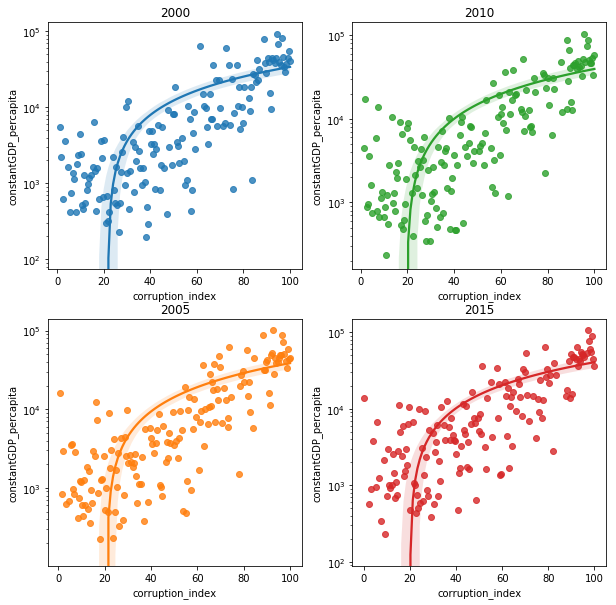

In [59]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
custom_plot(0,0,nodes_herf,"corruption_index","constantGDP_percapita",2000)
custom_plot(1,0,nodes_herf,"corruption_index","constantGDP_percapita",2005)
custom_plot(0,1,nodes_herf,"corruption_index","constantGDP_percapita",2010)
custom_plot(1,1,nodes_herf,"corruption_index","constantGDP_percapita",2015)

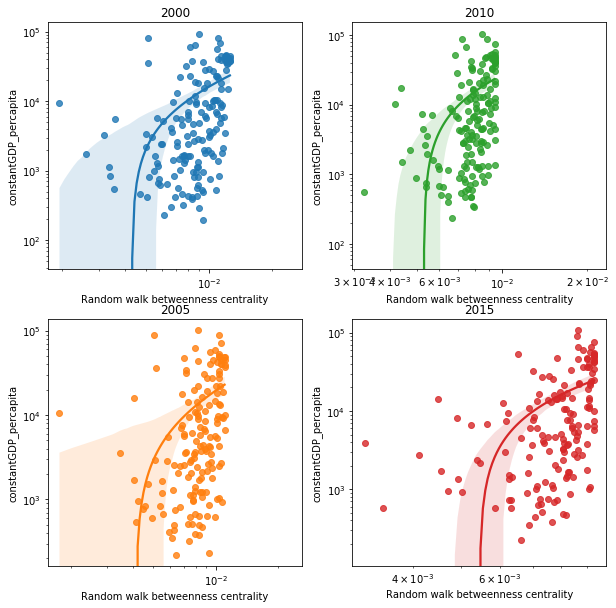

In [60]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
custom_plot2(0,0,nodes_herf,"Random walk betweenness centrality","constantGDP_percapita",2000)
custom_plot2(1,0,nodes_herf,"Random walk betweenness centrality","constantGDP_percapita",2005)
custom_plot2(0,1,nodes_herf,"Random walk betweenness centrality","constantGDP_percapita",2010)
custom_plot2(1,1,nodes_herf,"Random walk betweenness centrality","constantGDP_percapita",2015)

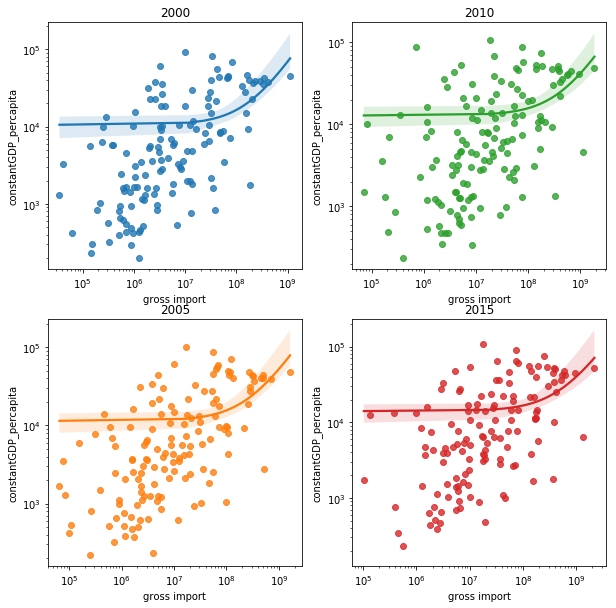

In [61]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
custom_plot2(0,0,nodes_herf,"gross import","constantGDP_percapita",2000)
custom_plot2(1,0,nodes_herf,"gross import","constantGDP_percapita",2005)
custom_plot2(0,1,nodes_herf,"gross import","constantGDP_percapita",2010)
custom_plot2(1,1,nodes_herf,"gross import","constantGDP_percapita",2015)

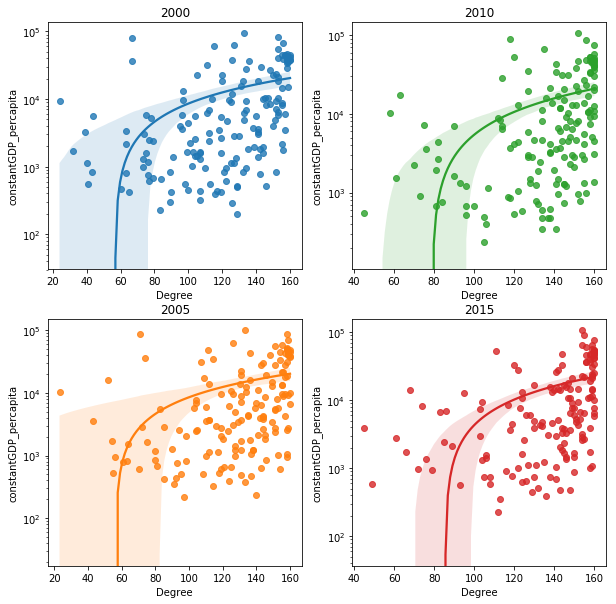

In [62]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
custom_plot(0,0,nodes,"Degree","constantGDP_percapita",2000)
custom_plot(1,0,nodes,"Degree","constantGDP_percapita",2005)
custom_plot(0,1,nodes,"Degree","constantGDP_percapita",2010)
custom_plot(1,1,nodes,"Degree","constantGDP_percapita",2015)

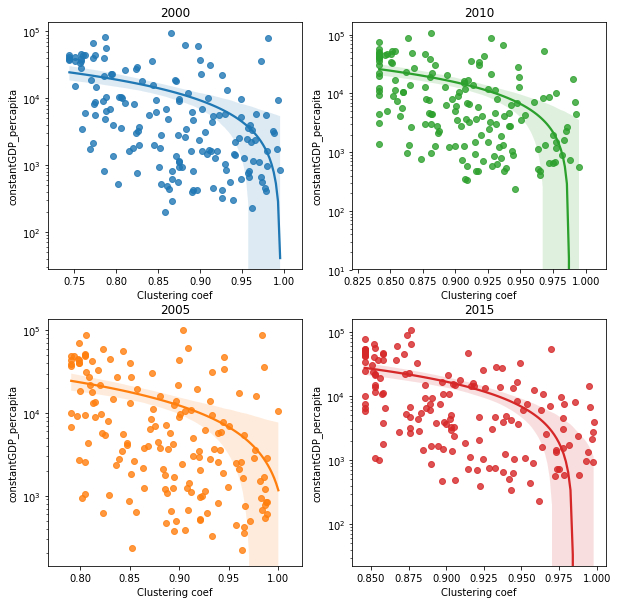

In [63]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
custom_plot(0,0,nodes,"Clustering coef","constantGDP_percapita",2000)
custom_plot(1,0,nodes,"Clustering coef","constantGDP_percapita",2005)
custom_plot(0,1,nodes,"Clustering coef","constantGDP_percapita",2010)
custom_plot(1,1,nodes,"Clustering coef","constantGDP_percapita",2015)

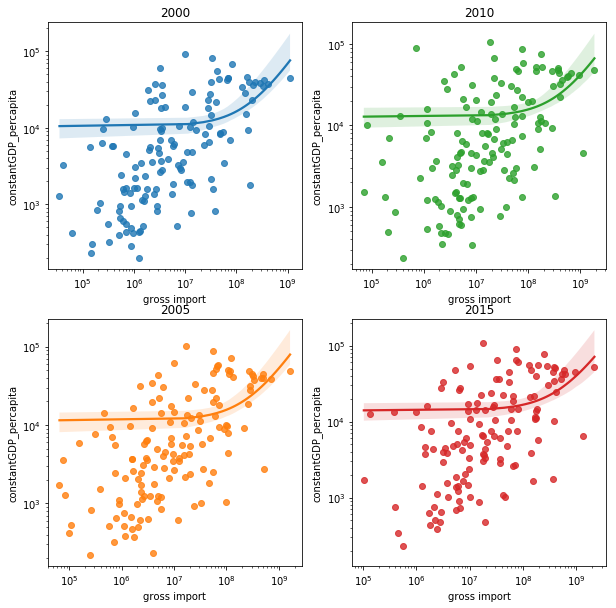

In [64]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
custom_plot2(0,0,nodes,"gross import","constantGDP_percapita",2000)
custom_plot2(1,0,nodes,"gross import","constantGDP_percapita",2005)
custom_plot2(0,1,nodes,"gross import","constantGDP_percapita",2010)
custom_plot2(1,1,nodes,"gross import","constantGDP_percapita",2015)

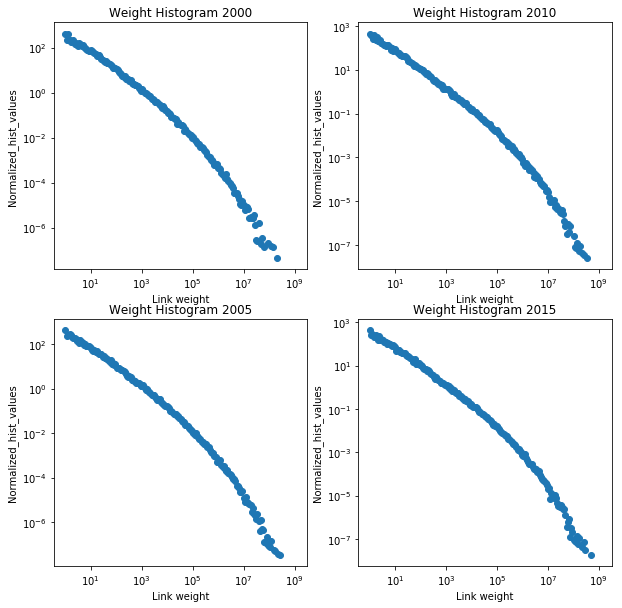

In [65]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
def logbinplot(ax,ay,edge,cim):
    bins = np.logspace(0,9.1, 200)
    widths = (bins[1:] - bins[:-1])
    hist = np.histogram(edge["weight"], bins=bins)
    hist_norm = hist[0]/widths
    axes[ax,ay].set_title("Weight Histogram %s" %cim)
    axes[ax,ay].set_ylabel("Normalized_hist_values")
    axes[ax,ay].set_xlabel("Link weight")
    axes[ax,ay].plot(bins[:-1], hist_norm, "o")
    axes[ax,ay].set_xscale('log')
    axes[ax,ay].set_yscale('log')
    
logbinplot(0,0,edges2000,2000)
logbinplot(1,0,edges2005,2005)
logbinplot(0,1,edges2010,2010)
logbinplot(1,1,edges2015,2015)

In [66]:
nodes_herf['log_Gdp']=nodes_herf['constantGDP_percapita'].apply(np.log)
nodes_herf

id       x       y   shape  year  Degree  \
0      2  0.5560  0.7286  0.5000  2000     101   
1     44  0.5046  0.6557  0.5000  2000     141   
2      1  0.5496  0.4378  0.5000  2000      63   
3      6  0.3283  0.5948  0.5000  2000      97   
4      4  0.3233  0.2866  0.5000  2000     146   
5      5  0.6251  0.7226  0.5000  2000      91   
6      7  0.8716  0.3596  0.5000  2000     157   
7      8  0.5404  0.7640  0.5000  2000     160   
8      9  0.6322  0.7230  0.5000  2000     103   
9     17  0.2850  0.6391  0.5000  2000     111   
10    16  0.6407  0.6441  0.5000  2000     120   
11    14  0.7510  0.6316  0.5000  2000     146   
12    23  0.3346  0.5733  0.5000  2000     131   
13    19  0.5776  0.7984  0.5000  2000     127   
14    11  0.5124  0.7806  0.5000  2000     156   
15    12  0.5064  0.5517  0.5000  2000     110   
16    20  0.3201  0.6796  0.5000  2000      67   
17    25  0.7512  0.6529  0.5000  2000      40   
18    21  0.3234  0.4095  0.5000  2000     107   
19    18  0.5491  0.7440  0.5000  2000      74   
20    26  0.5686  0.3760  0.5000  2000      78   
21    22  0.3558  0.4209  0.5000  2000     155   
22    24  0.8187  0.5252  0.5000  2000      67   
23    15  0.5708  0.7374  0.5000  2000     150   
24    13  0.4957  0.5680  0.5000  2000     117   
25    10  0.5831  0.4813  0.5000  2000      83   
26    84  0.7916  0.5698  0.5000  2000     107   
27    33  0.5343  0.5409  0.5000  2000     127   
28    28  0.2046  0.8118  0.5000  2000     158   
29    27  0.5582  0.5367  0.5000  2000      90   
30   141  0.5520  0.5859  0.5000  2000      60   
31    30  0.3013  0.3018  0.5000  2000     134   
32    31  0.7894  0.6992  0.5000  2000     156   
33    35  0.2936  0.5254  0.5000  2000     151   
34    36  0.6219  0.4340  0.5000  2000      73   
35    34  0.5440  0.4987  0.5000  2000      77   
36    37  0.2674  0.5542  0.5000  2000     133   
37    68  0.5422  0.7506  0.5000  2000     145   
38    38  0.5929  0.6951  0.5000  2000     148   
39    39  0.5430  0.7768  0.5000  2000     155   
40    32  0.4846  0.5419  0.5000  2000     128   
41    42  0.5264  0.8126  0.5000  2000     153   
42    41  0.3295  0.5856  0.5000  2000     104   
43    43  0.3051  0.6041  0.5000  2000      95   
44    45  0.2828  0.4898  0.5000  2000     138   
45    46  0.5856  0.6490  0.5000  2000     139   
46   134  0.2531  0.5766  0.5000  2000     119   
47    61  0.5285  0.5092  0.5000  2000      44   
48    47  0.6105  0.5843  0.5000  2000      43   
49    49  0.5695  0.8255  0.5000  2000     144   
50   139  0.5874  0.3527  0.5000  2000     112   
51    50  0.6125  0.5508  0.5000  2000     129   
52    52  0.9984  0.4079  0.5000  2000      63   
53    51  0.5715  0.8440  0.5000  2000     153   
54    53  0.5061  0.7568  0.5000  2000     160   
55    54  0.5322  0.4955  0.5000  2000     114   
56    59  0.4575  0.5747  0.5000  2000      89   
57    56  0.6204  0.7351  0.5000  2000      99   
58    40  0.5290  0.7843  0.5000  2000     160   
59    57  0.4972  0.5441  0.5000  2000     134   
60    62  0.5606  0.7171  0.5000  2000     152   
61    63  0.3289  0.5681  0.5000  2000     111   
62    64  0.2494  0.5877  0.5000  2000     104   
63    58  0.4731  0.5553  0.5000  2000     122   
64    60  0.4578  0.5656  0.5000  2000      41   
65    65  0.3363  0.5270  0.5000  2000     112   
66    69  0.2992  0.6054  0.5000  2000      76   
67    67  0.2604  0.5844  0.5000  2000     119   
68    66  0.8170  0.6244  0.5000  2000     150   
69    70  0.5542  0.7620  0.5000  2000     153   
70    75  0.4472  0.8609  0.5000  2000     126   
71    72  0.7193  0.6144  0.5000  2000     152   
72    71  0.8164  0.4956  0.5000  2000     155   
73    74  0.6491  0.6802  0.5000  2000     133   
74    73  0.4771  0.7967  0.5000  2000     157   
75    76  0.5968  0.6725  0.5000  2000     134   
76    77  0.5349  0.7326  0.5000  2000     158   
77    78  0.2853  0.6006  0.5000  2000     123   
78    80  0.8840  0.7011  0.5000  2000     159   
79    

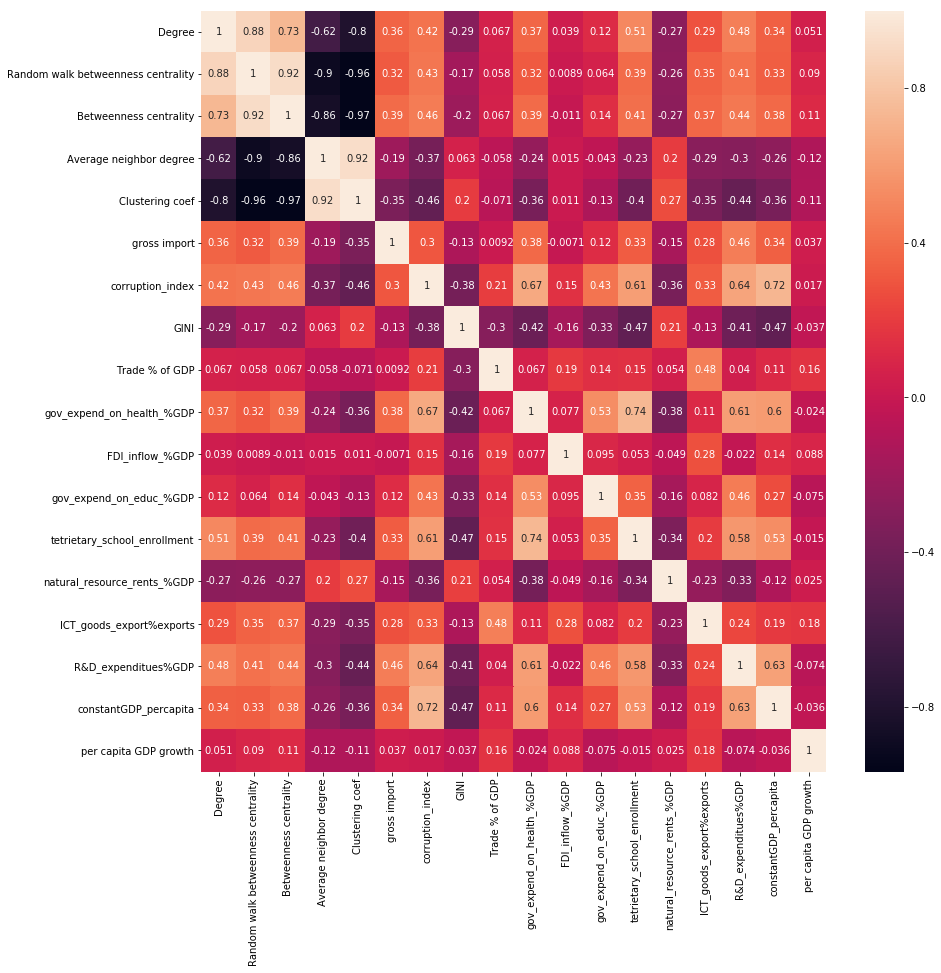

In [67]:
fig = plt.subplots(figsize=(14,14))
corrMatrix = nodes_herf.iloc[:,[*[5,6,7,8,9,13,15,16,18,19,20,21,22,23,24,25,14,17]]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [68]:
nodes_herf

id       x       y   shape  year  Degree  \
0      2  0.5560  0.7286  0.5000  2000     101   
1     44  0.5046  0.6557  0.5000  2000     141   
2      1  0.5496  0.4378  0.5000  2000      63   
3      6  0.3283  0.5948  0.5000  2000      97   
4      4  0.3233  0.2866  0.5000  2000     146   
5      5  0.6251  0.7226  0.5000  2000      91   
6      7  0.8716  0.3596  0.5000  2000     157   
7      8  0.5404  0.7640  0.5000  2000     160   
8      9  0.6322  0.7230  0.5000  2000     103   
9     17  0.2850  0.6391  0.5000  2000     111   
10    16  0.6407  0.6441  0.5000  2000     120   
11    14  0.7510  0.6316  0.5000  2000     146   
12    23  0.3346  0.5733  0.5000  2000     131   
13    19  0.5776  0.7984  0.5000  2000     127   
14    11  0.5124  0.7806  0.5000  2000     156   
15    12  0.5064  0.5517  0.5000  2000     110   
16    20  0.3201  0.6796  0.5000  2000      67   
17    25  0.7512  0.6529  0.5000  2000      40   
18    21  0.3234  0.4095  0.5000  2000     107   
19    18  0.5491  0.7440  0.5000  2000      74   
20    26  0.5686  0.3760  0.5000  2000      78   
21    22  0.3558  0.4209  0.5000  2000     155   
22    24  0.8187  0.5252  0.5000  2000      67   
23    15  0.5708  0.7374  0.5000  2000     150   
24    13  0.4957  0.5680  0.5000  2000     117   
25    10  0.5831  0.4813  0.5000  2000      83   
26    84  0.7916  0.5698  0.5000  2000     107   
27    33  0.5343  0.5409  0.5000  2000     127   
28    28  0.2046  0.8118  0.5000  2000     158   
29    27  0.5582  0.5367  0.5000  2000      90   
30   141  0.5520  0.5859  0.5000  2000      60   
31    30  0.3013  0.3018  0.5000  2000     134   
32    31  0.7894  0.6992  0.5000  2000     156   
33    35  0.2936  0.5254  0.5000  2000     151   
34    36  0.6219  0.4340  0.5000  2000      73   
35    34  0.5440  0.4987  0.5000  2000      77   
36    37  0.2674  0.5542  0.5000  2000     133   
37    68  0.5422  0.7506  0.5000  2000     145   
38    38  0.5929  0.6951  0.5000  2000     148   
39    39  0.5430  0.7768  0.5000  2000     155   
40    32  0.4846  0.5419  0.5000  2000     128   
41    42  0.5264  0.8126  0.5000  2000     153   
42    41  0.3295  0.5856  0.5000  2000     104   
43    43  0.3051  0.6041  0.5000  2000      95   
44    45  0.2828  0.4898  0.5000  2000     138   
45    46  0.5856  0.6490  0.5000  2000     139   
46   134  0.2531  0.5766  0.5000  2000     119   
47    61  0.5285  0.5092  0.5000  2000      44   
48    47  0.6105  0.5843  0.5000  2000      43   
49    49  0.5695  0.8255  0.5000  2000     144   
50   139  0.5874  0.3527  0.5000  2000     112   
51    50  0.6125  0.5508  0.5000  2000     129   
52    52  0.9984  0.4079  0.5000  2000      63   
53    51  0.5715  0.8440  0.5000  2000     153   
54    53  0.5061  0.7568  0.5000  2000     160   
55    54  0.5322  0.4955  0.5000  2000     114   
56    59  0.4575  0.5747  0.5000  2000      89   
57    56  0.6204  0.7351  0.5000  2000      99   
58    40  0.5290  0.7843  0.5000  2000     160   
59    57  0.4972  0.5441  0.5000  2000     134   
60    62  0.5606  0.7171  0.5000  2000     152   
61    63  0.3289  0.5681  0.5000  2000     111   
62    64  0.2494  0.5877  0.5000  2000     104   
63    58  0.4731  0.5553  0.5000  2000     122   
64    60  0.4578  0.5656  0.5000  2000      41   
65    65  0.3363  0.5270  0.5000  2000     112   
66    69  0.2992  0.6054  0.5000  2000      76   
67    67  0.2604  0.5844  0.5000  2000     119   
68    66  0.8170  0.6244  0.5000  2000     150   
69    70  0.5542  0.7620  0.5000  2000     153   
70    75  0.4472  0.8609  0.5000  2000     126   
71    72  0.7193  0.6144  0.5000  2000     152   
72    71  0.8164  0.4956  0.5000  2000     155   
73    74  0.6491  0.6802  0.5000  2000     133   
74    73  0.4771  0.7967  0.5000  2000     157   
75    76  0.5968  0.6725  0.5000  2000     134   
76    77  0.5349  0.7326  0.5000  2000     158   
77    78  0.2853  0.6006  0.5000  2000     123   
78    80  0.8840  0.7011  0.5000  2000     159   
79    

# sliding plotokhoz

In [73]:
sliding=nodes_herf[['year','name','gross import']].sort_values(['year','gross import'], ascending=False)
sliding1=sliding[sliding['year']==2000].iloc[:10,:]
sliding1['index']=range(1,11)
sliding2=sliding[sliding['year']==2005].iloc[:10,:]
sliding2['index']=range(1,11)
sliding3=sliding[sliding['year']==2010].iloc[:10,:]
sliding3['index']=range(1,11)
sliding4=sliding[sliding['year']==2015].iloc[:10,:]
sliding4['index']=range(1,11)

frames=[sliding1,sliding2,sliding3,sliding4]
sliding_df=pd.concat(frames, axis=0).reset_index(drop=True)
sliding_df['gross import']=sliding_df['gross import'].apply(lambda x: round(float(x),2)/1000000)

In [74]:
sliding_df

year                name  gross import  index
0   2000       United States   1120.224816      1
1   2000             Germany    417.267876      2
2   2000               Japan    354.689613      3
3   2000      United Kingdom    335.941159      4
4   2000              France    293.451806      5
5   2000              Canada    228.237451      6
6   2000               Italy    215.960565      7
7   2000           Hong Kong    197.825700      8
8   2000               China    188.749019      9
9   2000             Belgium    173.108103     10
10  2005       United States   1626.791187      1
11  2005             Germany    703.409199      2
12  2005               China    521.976443      3
13  2005      United Kingdom    489.296499      4
14  2005               Japan    487.694955      5
15  2005              France    460.782675      6
16  2005               Italy    338.476122      7
17  2005             Belgium    313.237001      8
18  2005              Canada    302.259896      9
19  2005               Spain    279.855729     10
20  2010       United States   1858.501040      1
21  2010               China   1129.591295      2
22  2010             Germany    962.284236      3
23  2010               Japan    655.218573      4
24  2010              France    571.925696      5
25  2010      United Kingdom    554.089804      6
26  2010               Italy    447.931965      7
27  2010           Hong Kong    411.962435      8
28  2010  Korea, Republic of    405.748426      9
29  2010             Belgium    384.467941     10
30  2015       United States   2178.876253      1
31  2015               China   1354.704497      2
32  2015             Germany    950.752929      3
33  2015      United Kingdom    605.368008      4
34  2015               Japan    590.178698      5
35  2015              France    538.667527      6
36  2015           Hong Kong    522.441337      7
37  2015  Korea, Republic of    411.112637      8
38  2015              Canada    403.269269      9
39  2015               Italy    386.084945     10

In [79]:
el1=edges2000.groupby(['source','target']).sum().sort_values('weight', ascending=False).reset_index()[:10]
el1['year']=2000
el1['index']=range(1,11)
el1['name']=el1['source']+" - "+el1['target']

el2=edges2005.groupby(['source','target']).sum().sort_values('weight', ascending=False).reset_index()[:10]
el2['year']=2005
el2['index']=range(1,11)
el2['name']=el2['source']+" - "+el2['target']

el3=edges2010.groupby(['source','target']).sum().sort_values('weight', ascending=False).reset_index()[:10]
el3['year']=2010
el3['index']=range(1,11)
el3['name']=el3['source']+" - "+el3['target']

el4=edges2015.groupby(['source','target']).sum().sort_values('weight', ascending=False).reset_index()[:10]
el4['year']=2015
el4['index']=range(1,11)
el4['name']=el4['source']+" - "+el4['target']

frames=[el1,el2,el3,el4]
sliding_df2=pd.concat(frames, axis=0).reset_index(drop=True)
sliding_df2['weight']=sliding_df2['weight'].apply(lambda x: round(float(x),2)/1000000)
sliding_df2

source target       weight  year  index       name
0     USA    WLD  1169.490648  2000      1  USA - WLD
1     DEU    WLD   440.722799  2000      2  DEU - WLD
2     JPN    WLD   374.125198  2000      3  JPN - WLD
3     GBR    WLD   348.243125  2000      4  GBR - WLD
4     FRA    WLD   303.653791  2000      5  FRA - WLD
5     CAN    WLD   235.384522  2000      6  CAN - WLD
6     ITA    WLD   228.844710  2000      7  ITA - WLD
7     CHN    WLD   223.187676  2000      8  CHN - WLD
8     USA    CAN   216.099263  2000      9  USA - CAN
9     HKG    WLD   213.914176  2000     10  HKG - WLD
10    USA    WLD  1679.404513  2005      1  USA - WLD
11    DEU    WLD   746.116932  2005      2  DEU - WLD
12    CHN    WLD   657.630936  2005      3  CHN - WLD
13    JPN    WLD   507.838477  2005      4  JPN - WLD
14    GBR    WLD   504.082335  2005      5  GBR - WLD
15    FRA    WLD   475.730355  2005      6  FRA - WLD
16    ITA    WLD   361.338720  2005      7  ITA - WLD
17    BEL    WLD   316.743191  2005      8  BEL - WLD
18    CAN    WLD   309.713248  2005      9  CAN - WLD
19    HKG    WLD   299.937067  2005     10  HKG - WLD
20    USA    WLD  1911.925808  2010      1  USA - WLD
21    CHN    WLD  1377.328329  2010      2  CHN - WLD
22    DEU    WLD  1020.376321  2010      3  DEU - WLD
23    JPN    WLD   681.987774  2010      4  JPN - WLD
24    FRA    WLD   598.876533  2010      5  FRA - WLD
25    GBR    WLD   567.381018  2010      6  GBR - WLD
26    ITA    WLD   480.363078  2010      7  ITA - WLD
27    HKG    WLD   441.173610  2010      8  HKG - WLD
28    KOR    WLD   425.147408  2010      9  KOR - WLD
29    BEL    WLD   386.758992  2010     10  BEL - WLD
30    USA    WLD  2228.351501  2015      1  USA - WLD
31    CHN    WLD  1672.428992  2015      2  CHN - WLD
32    DEU    WLD  1008.977701  2015      3  DEU - WLD
33    GBR    WLD   621.172728  2015      4  GBR - WLD
34    JPN    WLD   614.872607  2015      5  JPN - WLD
35    FRA    WLD   563.008941  2015      6  FRA - WLD
36    HKG    WLD   559.095084  2015      7  HKG - WLD
37    USA    CHN   498.423201  2015      8  USA - CHN
38    KOR    WLD   436.486844  2015      9  KOR - WLD
39    CAN    WLD   411.083871  2015     10  CAN - WLD

In [77]:
sliding_df.to_csv('sliding.csv')
sliding_df2.to_csv('sliding2.csv')

In [69]:
nodes_herf.to_csv('data.csv',index=False)

In [18]:
# Öko + plotolás

Trade network Backbone plotok

In [461]:
def plot_gen(edges):
    Y=nx.Graph()
    edges1=edges.groupby(['source']).agg({'weight':sum})
    edges2=edges.groupby('target').sum()
    edges1=edges1.merge(edges2, left_index=True, right_index=True, how='outer')
    edges1=edges1.fillna(0)
    edges1['weight']=edges1['weight_x']+edges1['weight_y']
    edges1=edges1.drop(columns=['weight_x','weight_y'])
    indexek=edges1.sort_values('weight', ascending=False).index[:10]
    
    edges=edges[edges['source'].isin(indexek)]
    edges=edges[edges['target'].isin(indexek)]

    #edges=edges.sort_values('weight',ascending=False)[:int(len(edges)/200)]
    Y=nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])

    
    mask2=mask.merge(edges1, left_on='index', right_index=True, how='left')
    
    nx.set_node_attributes(Y, mask2.set_index('index').to_dict('index'))
    
    return Y

Z2000=plot_gen(edges2000)
Z2005=plot_gen(edges2005)
Z2010=plot_gen(edges2010)
Z2015=plot_gen(edges2015)
Z2018=plot_gen(edges2018)


In [463]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False):
        from pyvis import network as net
        pyvis_graph = net.Network(notebook=notebook, height="1000px", width="100%",
                                  bgcolor="#222222", font_color="white", directed=True)
        #pyvis_graph.force_atlas_2based(gravity=-100, central_gravity=0.01, spring_length=150,
        #                               spring_strength=0.05, damping=0.5, overlap=0)
        for node,node_attrs in networkx_graph.nodes(data=True):
            pyvis_graph.add_node(node,**node_attrs, color="#dd4b39")    
        for source,target,edge_attrs in networkx_graph.edges(data=True):
            if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
                edge_attrs['value']=edge_attrs['weight']
            pyvis_graph.add_edge(source,target,**edge_attrs, arrowStrikethrough=False)
        neighbor_map=pyvis_graph.get_adj_list()
        for node in pyvis_graph.nodes:
            node["value"]=len(neighbor_map[node["id"]])
        pyvis_graph.toggle_physics(False)
        return pyvis_graph.show(output_filename)

def draw_graph(networkx_graph,notebook=True,output_filename='graph.html'):
    from pyvis import network as net
    pyvis_graph = net.Network(notebook=notebook, height="800px", width="100%",
                                bgcolor="#222222", font_color="white", directed=True)
    pyvis_graph.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=150,
                            spring_strength=0.05, damping=0.5, overlap=0)
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,x=node_attrs['x']*2000,y=-(node_attrs['y'])*2000,value=node_attrs['weight'], color="#dd4b39", physics=False)
        
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            edge_attrs['value']=edge_attrs['weight']
        pyvis_graph.add_edge(source,target,**edge_attrs, arrowStrikethrough=True)
    for node in pyvis_graph.nodes:
        pyvis_graph.toggle_physics(False)
    return pyvis_graph.show(output_filename)


In [465]:
draw_graph(Z2000)

In [466]:
draw_graph(Z2005)

In [467]:
draw_graph(Z2010)

In [468]:
draw_graph(Z2015)

In [469]:
draw_graph(Z2018)

In [119]:
wbdata.search_indicators('public expenditure')

BI.WAG.TOTL.PB.ZS	Wage bill as a percentage of Public Expenditure
SE.XPD.EDUC.ZS   	Public Expenditure on Education  (% GDP)
SH.XPD.HLTH.ZS   	Public Expenditure on Health (% GDP)


Public expenditure, FDI, education level, private investment, capital labor ratio, natural resources, infrastructure, technology, law, human capital,
Foldrajzi valtozok (landlocked), WTO tagsag, atlagos iskolazottsag (human capital proxy), esetleg nyersanyag boseg



In [26]:
data_date=(datetime.datetime(2015, 1, 1))
len(wbdata.get_data('SH.XPD.GHED.GD.ZS', data_date=data_date))

264

In [21]:
nodes=nodes_gen(Y2000, 2000, nodess)
nodes=nodes_gen(Y2005, 2005, nodes)
nodes=nodes_gen(Y2010, 2010, nodes)
nodes=nodes_gen(Y2015, 2015, nodes)

In [95]:
nodes=nodes_gen(Y2000, 2000, nodess)
nodes=nodes_gen(Y2005, 2005, nodes)
nodes=nodes_gen(Y2010, 2010, nodes)
nodes=nodes_gen(Y2015, 2015, nodes)
input_countries=nodes.index
input_countries=pd.DataFrame(input_countries, columns=["Countries"])

iso2=[]
iso3=[]
count=[]
countries = {}
for country in pycountry.countries:
    iso2.append(country.alpha_2)
    iso3.append(country.alpha_3)
    count.append(country.name)
    
countries=pd.DataFrame(iso3,iso2, columns=["iso3"]).reset_index()
countries["name"]=count
nodes=nodes.merge(countries,left_index=True, right_on="iso3",how='left')


def wbadat(times, tab, indicat, name):
    indicator={indicat:name}
    tab2=pd.DataFrame()
    for i in times:
        data_date = (datetime.datetime(i, 1, 1))
        try:
            population=wbdata.get_data(indicat, data_date=data_date)
            population=pd.DataFrame(population).drop(columns=['decimal','indicator','date'])
            population['index']=[f['id'] for f in population['country']]
            population=population.drop(columns=["country"])
            population=population.dropna()
            population['value']=round(population['value'].astype(float),2)
            population=population.rename(columns={"value":name})
            
            tab1=tab.merge(population, left_on=["index"], right_on=["index"], how="left")
            
            tab1=tab1[tab1['year']==i]
            if i==2000:
                tab2=tab1
            else:
                frames=[tab1,tab2]
                tab2=pd.concat(frames, axis=0)

        except:
            'foo'        
    return tab2

dates=[2000,2005,2010,2015]


nodes=wbadat(dates, nodes,'NY.GDP.PCAP.KD', "constantGDP_percapita")
nodes=wbadat(dates, nodes,'CC.PER.RNK', "corruption_index")
nodes=wbadat(dates, nodes,'SI.POV.GINI', "GINI")

nodes=nodes.sort_values(['year','name'])

id       x       y   shape  year  Degree  Clustering coef index iso3  \
483    2  0.5560  0.7286  0.5000  2000     101         0.941584    AL  ALB   
574   44  0.5046  0.6557  0.5000  2000     141         0.805572    DZ  DZA   
562    1  0.5496  0.4378  0.5000  2000      63         0.960573    AO  AGO   
625    6  0.3283  0.5948  0.5000  2000      97         0.932775    AG  ATG   
485    4  0.3233  0.2866  0.5000  2000     146         0.821256    AR  ARG   
486    5  0.6251  0.7226  0.5000  2000      91         0.941636    AM  ARM   
487    7  0.8716  0.3596  0.5000  2000     157         0.761146    AU  AUS   
488    8  0.5404  0.7640  0.5000  2000     160         0.744340    AT  AUT   
489    9  0.6322  0.7230  0.5000  2000     103         0.911289    AZ  AZE   
566   17  0.2850  0.6391  0.5000  2000     111         0.912367    BS  BHS   
565   16  0.6407  0.6441  0.5000  2000     120         0.900700    BH  BHR   
564   14  0.7510  0.6316  0.5000  2000     146         0.802078    BD  BGD   
567   23  0.3346  0.5733  0.5000  2000     131         0.843570    BB  BRB   
493   19  0.5776  0.7984  0.5000  2000     127         0.853393    BY  BLR   
490   11  0.5124  0.7806  0.5000  2000     156         0.771878    BE  BEL   
630   12  0.5064  0.5517  0.5000  2000     110         0.878899    BJ  BEN   
626   20  0.3201  0.6796  0.5000  2000      67         0.980552    BM  BMU   
632   25  0.7512  0.6529  0.5000  2000      40         0.970513    BT  BTN   
494   21  0.3234  0.4095  0.5000  2000     107         0.919767    BO  BOL   
492   18  0.5491  0.7440  0.5000  2000      74         0.987782    BA  BIH   
568   26  0.5686  0.3760  0.5000  2000      78         0.949051    BW  BWA   
495   22  0.3558  0.4209  0.5000  2000     155         0.774445    BR  BRA   
631   24  0.8187  0.5252  0.5000  2000      67         0.972863    BN  BRN   
491   15  0.5708  0.7374  0.5000  2000     150         0.796689    BG  BGR   
563   13  0.4957  0.5680  0.5000  2000     117         0.863101    BF  BFA   
629   10  0.5831  0.4813  0.5000  2000      83         0.961505    BI  BDI   
587   84  0.7916  0.5698  0.5000  2000     107         0.891730    KH  KHM   
570   33  0.5343  0.5409  0.5000  2000     127         0.875266    CM  CMR   
497   28  0.2046  0.8118  0.5000  2000     158         0.758123    CA  CAN   
496   27  0.5582  0.5367  0.5000  2000      90         0.926841    CF  CAF   
613  141  0.5520  0.5859  0.5000  2000      60         0.977401    TD  TCD   
569   30  0.3013  0.3018  0.5000  2000     134         0.847267    CL  CHL   
499   31  0.7894  0.6992  0.5000  2000     156         0.769065    CN  CHN   
501   35  0.2936  0.5254  0.5000  2000     151         0.786225    CO  COL   
572   36  0.6219  0.4340  0.5000  2000      73         0.952055    KM  COM   
571   34  0.5440  0.4987  0.5000  2000      77         0.956254    CG  COG   
502   37  0.2674  0.5542  0.5000  2000     133         0.847915    CR  CRI   
517   68  0.5422  0.7506  0.5000  2000     145         0.805747    HR  HRV   
503   38  0.5929  0.6951  0.5000  2000     148         0.810995    CY  CYP   
504   39  0.5430  0.7768  0.5000  2000     155         0.775618    CZ  CZE   
500   32  0.4846  0.5419  0.5000  2000     128         0.871186    CI  CIV   
506   42  0.5264  0.8126  0.5000  2000     153         0.788356    DK  DNK   
627   41  0.3295  0.5856  0.5000  2000     104         0.922704    DM  DMA   
573   43  0.3051  0.6041  0.5000  2000      95         0.960134    DO  DOM   
507   45  0.2828  0.4898  0.5000  2000     138         0.827674    EC  ECU   
508   46  0.5856  0.6490  0.5000  2000     139         0.845272    EG  EGY   
611  134  0.2531  0.5766  0.5000  2000     119         0.882211    SV  SLV   
642   61  0.5285  0.5092  0.5000  2000      44         0.978858    GQ  GNQ   
633   47  0.6105  0.5843  0.5000  2000      43         0.995570    ER  ERI   
510   49  0.5695  0.8255  0.5000  2000     144         0.807012    EE  EST   
612  139  0.5874  0.3527  0.

In [ ]:
def gdp(row):
    if row['year']==2000:
        val=row['constantGDP_percapita2000']
    elif row['year']==2005:
        val=row['constantGDP_percapita2005']
    elif row['year']==2010:
        val=row['constantGDP_percapita2010']
    elif row['year']==2015:
        val=row['constantGDP_percapita2015']
    return val    

def corruption(row):
    if row['year']==2000:
        val=row['corruption_index2000']
    elif row['year']==2005:
        val=row['corruption_index2005']
    elif row['year']==2010:
        val=row['corruption_index2010']
    elif row['year']==2015:
        val=row['corruption_index2000']
    return val    

def Gini(row):
    if row['year']==2000:
        val=row['GINI2000']
    elif row['year']==2005:
        val=row['GINI2005']
    elif row['year']==2010:
        val=row['GINI2010']
    elif row['year']==2015:
        val=row['GINI2015']
    return val    

def HDI(row):
    if row['year']==2000:
        val=row['HDI2000']
    elif row['year']==2005:
        val=row['HDI2005']
    elif row['year']==2010:
        val=row['HDI2010']
    else:
        val=np.nan
    return val    

nodes['GDP_percap']=nodes.apply(gdp, axis=1)
nodes['corruption']=nodes.apply(corruption, axis=1)
nodes['GINI']=nodes.apply(Gini, axis=1)
nodes['HDI']=nodes.apply(HDI, axis=1)
dropcols=nodes.iloc[:,10:25].columns
nodes=nodes.drop(columns=dropcols)

In [ ]:
gross2000=edges2000.groupby('source').sum().rename(columns={'weight':'gross import'})
gross2005=edges2005.groupby('source').sum().rename(columns={'weight':'gross import'})
gross2010=edges2010.groupby('source').sum().rename(columns={'weight':'gross import'})
gross2015=edges2015.groupby('source').sum().rename(columns={'weight':'gross import'})
#gross2018=edges2018.groupby('source').sum()

imp00=nodes.merge(gross2000, left_on='iso3', right_index=True, how='left')
imp00=imp00[imp00['year']==2000]
imp05=nodes.merge(gross2005, left_on='iso3', right_index=True, how='left')
imp05=imp05[imp05['year']==2005]
imp10=nodes.merge(gross2010, left_on='iso3', right_index=True, how='left')
imp10=imp10[imp10['year']==2010]
imp15=nodes.merge(gross2015, left_on='iso3', right_index=True, how='left')
imp15=imp15[imp15['year']==2015]
nodes=pd.concat([imp00,imp05,imp10,imp15], axis=0)
nodes=nodes.sort_values(['year','name'])
nodes

In [460]:
'''Y=nx.Graph()
edges=edges2000.sort_values('weight',ascending=False)[:int(len(edges2000)/200)]
Y=nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])

nx.set_node_attributes(Y, mask.set_index('index').to_dict('index'))
Y.nodes(data=True)
edges1=edges.groupby(['source']).agg({'weight':sum})
edges2=edges.groupby('target').sum()
#mask.merge(edges.groupby('source').sum(), left_on='index', right_index=True)
edges1=edges1.merge(edges2, left_index=True, right_index=True, how='outer')
edges1=edges1.fillna(0)
edges1['weight']=edges1['weight_x']+edges1['weight_y']
edges1=edges1.drop(columns=['weight_x','weight_y'])
edges1.sort_values('weight')'''

"Y=nx.Graph()\nedges=edges2000.sort_values('weight',ascending=False)[:int(len(edges2000)/200)]\nY=nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])\n\nnx.set_node_attributes(Y, mask.set_index('index').to_dict('index'))\nY.nodes(data=True)\nedges1=edges.groupby(['source']).agg({'weight':sum})\nedges2=edges.groupby('target').sum()\n#mask.merge(edges.groupby('source').sum(), left_on='index', right_index=True)\nedges1=edges1.merge(edges2, left_index=True, right_index=True, how='outer')\nedges1=edges1.fillna(0)\nedges1['weight']=edges1['weight_x']+edges1['weight_y']\nedges1=edges1.drop(columns=['weight_x','weight_y'])\nedges1.sort_values('weight')"